Link to the dataset [Fake and Real News](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset "Fake and Real News").

If some plots are not displayed, take a look through nbviewer [Link to Notebook](https://nbviewer.org/github/eugbutski/ds-projects/blob/b6385c80322bc8177eb369a14a8854ccf40fdf23/fake_real_news_nlp/NLP_News.ipynb "Link to Notebook").

## imports

In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

# sklearn for nlp

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from time import perf_counter

Originally there are a two datases for each category (fake and real news), that have the same columns. So, let's 'label' column in order to distinguish them and merge.

## 1. Data preparation, clearing and exploration

In [2]:
fake_df = pd.read_csv('dataset/Fake.csv')
true_df = pd.read_csv('dataset/True.csv')

# 0 for true, 1 for fake
fake_df['label'] = 1
true_df['label'] = 0
news = pd.concat([fake_df, true_df], ignore_index=True, axis=0)

In [3]:
(fake_df.shape[0] + true_df.shape[0]) == news.shape[0]

True

In [4]:
news.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 30, 2017      1  
3  December 29, 2017      1  
4  December 25, 2017      1

In [5]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


During casting the 'date' column into datetime, there were found some strange entries, which have contained only https links in every column or text on date column, so they have been automaticaly marked as NaNs in order to be deleted lately. Alhough, the dataset is not very big, it is a good choice to "cast down" a target variable to something smaller int type, i.e. 8 bits int, even though it makes not a really big difference for this dataset.

In [6]:
news['label'] = news['label'].astype('int8')
news['date'] = pd.to_datetime(news['date'], errors='coerce') # to mark not a date as NaN

In [7]:
news.isna().sum()

title       0
text        0
subject     0
date       10
label       0
dtype: int64

There were not so many of them and only in date column as well, so they could be safely dropped

In [8]:
news.dropna(inplace=True)

In [9]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    44888 non-null  object        
 1   text     44888 non-null  object        
 2   subject  44888 non-null  object        
 3   date     44888 non-null  datetime64[ns]
 4   label    44888 non-null  int8          
dtypes: datetime64[ns](1), int8(1), object(3)
memory usage: 1.8+ MB


In [10]:
# Extract some date realted columns
news['day_of_week'] = news['date'].dt.dayofweek
news['year'] = news['date'].dt.year
news['month'] = news['date'].dt.month

In [11]:
news.groupby('label')['year'].value_counts().sort_index()

label  year
0      2016     4716
       2017    16701
1      2015     2479
       2016    11754
       2017     9203
       2018       35
Name: year, dtype: int64

In [12]:
gb_label = news.groupby('label')

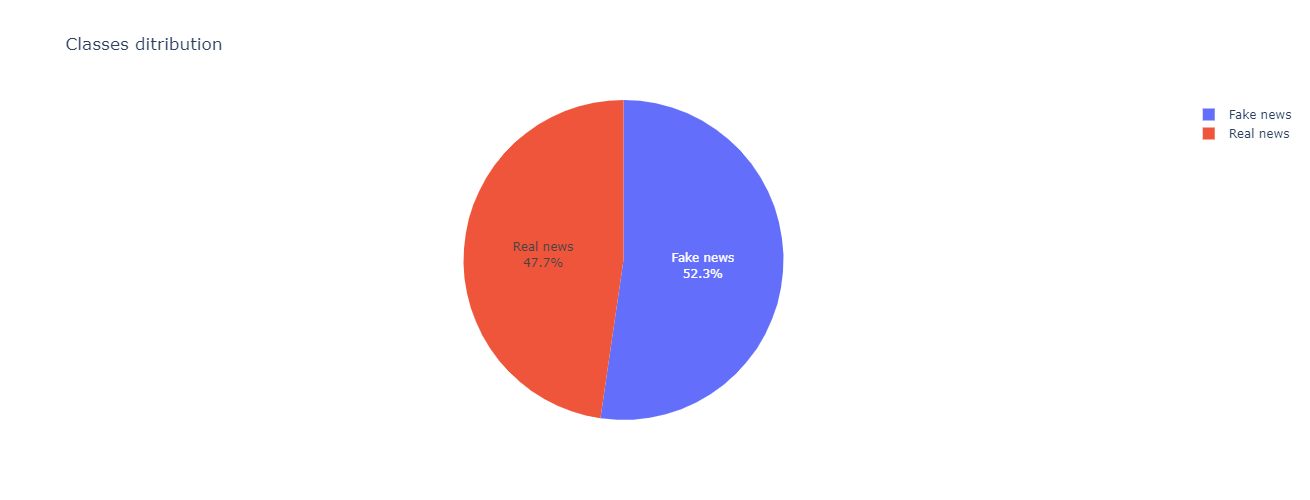

In [13]:
# Pie plot for News type
fig = go.Figure(data=[go.Pie(labels=['Fake news', 'Real news'],
                             values=news.label.value_counts(),
                             textinfo='label+percent')])
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    title_text='Classes ditribution')
fig.show()

In [7]:
labels = ['Real News', 'Fake News']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
newstype = {'0': 'Real news', '1': 'Fake news'}

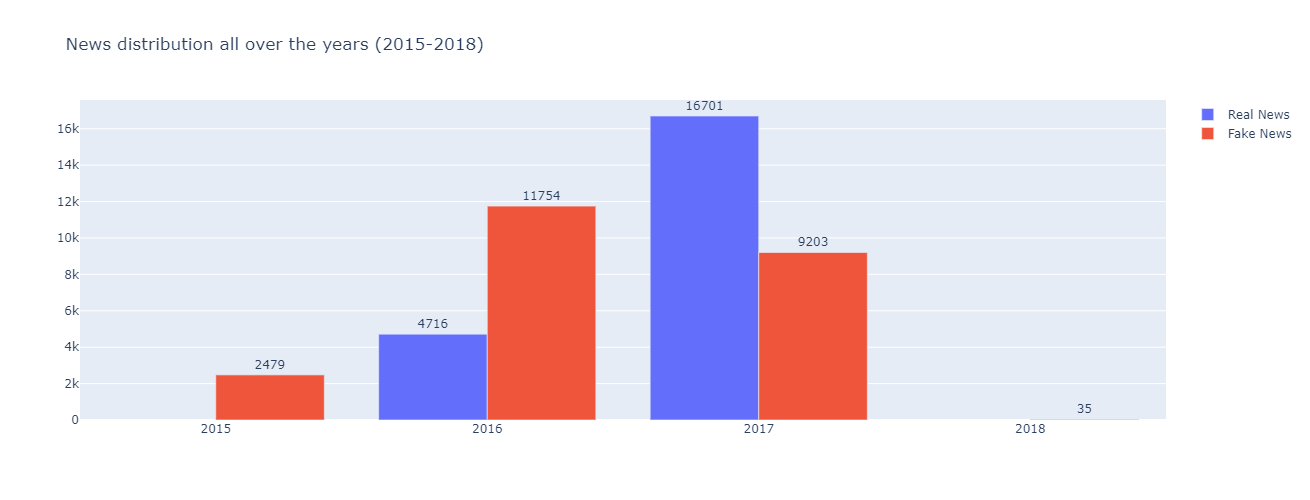

In [15]:
fig = go.Figure()
for i, label in enumerate(labels):
    fig.add_trace(go.Bar(name=label, x=gb_label.get_group(i)['year'].value_counts().index,
               y=gb_label.get_group(i)['year'].value_counts().values,
               text=gb_label.get_group(i)['year'].value_counts().values,
               textposition='outside'))
fig.update_layout(
    autosize=False,
    width=700,
    height=500,
    title_text='News distribution all over the years (2015-2018)')
fig.show()

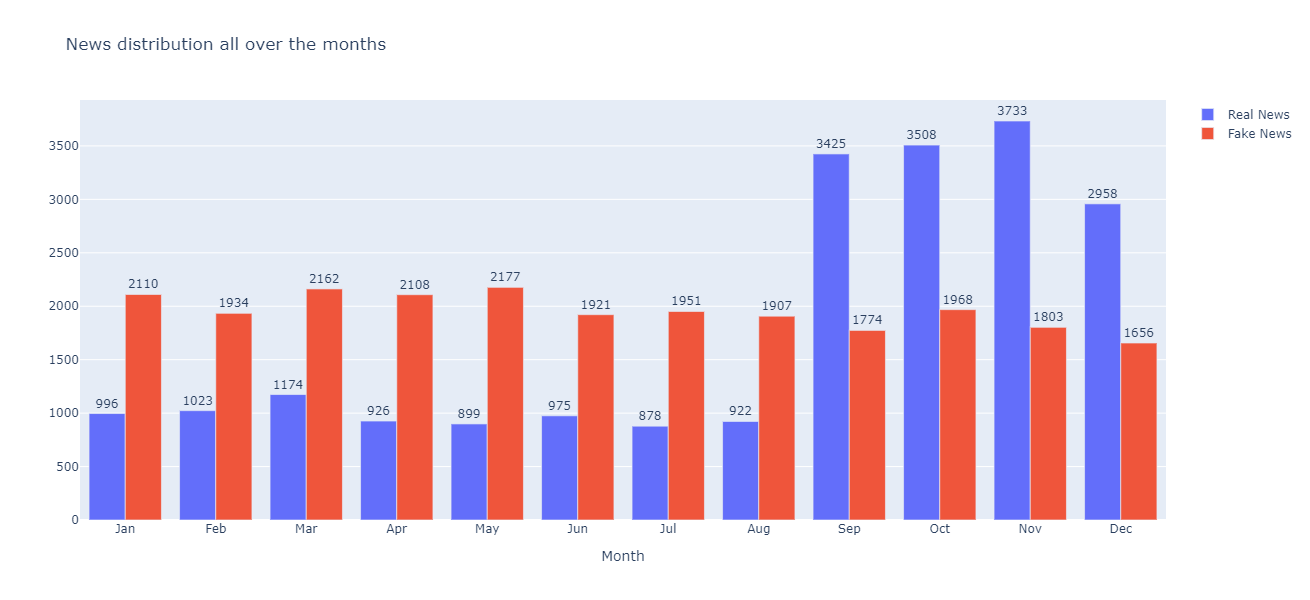

In [16]:
fig = go.Figure()
for i, label in enumerate(labels):
    fig.add_trace(go.Bar(name=label, x=gb_label.get_group(i)['month'].value_counts().index,
               y=gb_label.get_group(i)['month'].value_counts().values,
               text=gb_label.get_group(i)['month'].value_counts().values,
               textposition='outside'))
fig.update_xaxes(title_text='Month',
                 ticktext=months,
                 tickvals=list(range(1,13)))
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_text='News distribution all over the months')
fig.show()

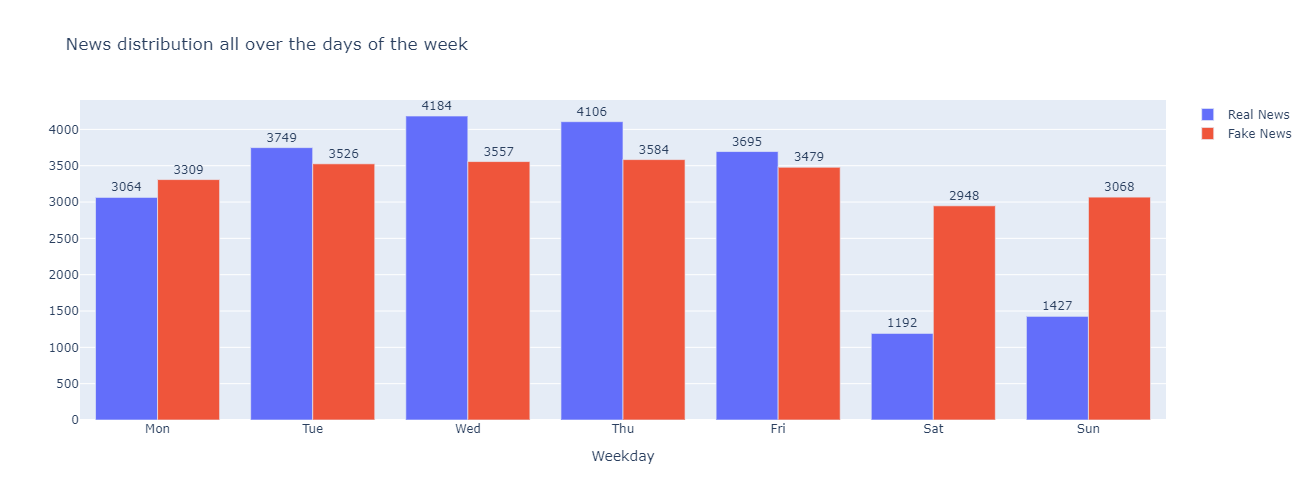

In [17]:
fig = go.Figure()
for i, label in enumerate(labels):
    fig.add_trace(go.Bar(name=label, x=gb_label.get_group(i)['day_of_week'].value_counts().index,
               y=gb_label.get_group(i)['day_of_week'].value_counts().values,
               text=gb_label.get_group(i)['day_of_week'].value_counts().values,
               textposition='outside'))
fig.update_xaxes(title_text='Weekday',
                 ticktext=weekday,
                 tickvals=list(range(0,8)))
fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text='News distribution all over the days of the week')
fig.show()

In [18]:
# Define some usefull functions in order to clean textual data

def clean_text(text):
    """
    Convert text to lowercase, using regex remove square brackets, links,
    new lines, punctuation and words containing numbers. Return clean text.

    Args:
        text (string): text to be cleaned

    Returns:
        text (string): cleaned text
    """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def process_text(text, ps=stemmer, lemm=lemmatizer):
    """
    Removes stopwords, uses stemmer and lemmatizer on tokens.

    Args:
        text (string): text to be pre-processed
        ps (PorterStemmer() object): Porter Stemmer from nltk package
        lemm (WordNetLemmatizer() object): Word Net Lemmatizer from nltk package

    Returns:
        lemm: stemmed and lemmatized without stopwords text
    """

    words = [word for word in text.split() if word not in stopwords.words('english')]
    stemmed_words = [ps.stem(w) for w in words]
    lemm = ', '.join([lemm.lemmatize(w) for w in stemmed_words])
    return lemm

In [23]:
news['clean_title'] = news.title.apply(lambda x: clean_text(x))
news['clean_text'] = news.text.apply(lambda x: clean_text(x))

In [24]:
news['word_count_title'] = news.loc[:, 'clean_title'].apply(lambda x: len([word for word in x.split()]))
news['word_count_text'] = news.loc[:, 'clean_text'].apply(lambda x: len([word for word in x.split()]))

In [105]:
news.isna().sum()

title               0
text                0
subject             0
date                0
label               0
day_of_week         0
year                0
month               0
clean_title         0
clean_text          0
word_count_title    0
word_count_text     0
processed_text      0
dtype: int64

In [104]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 44897
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             44888 non-null  object        
 1   text              44888 non-null  object        
 2   subject           44888 non-null  object        
 3   date              44888 non-null  datetime64[ns]
 4   label             44888 non-null  int8          
 5   day_of_week       44888 non-null  int64         
 6   year              44888 non-null  int64         
 7   month             44888 non-null  int64         
 8   clean_title       44888 non-null  object        
 9   clean_text        44888 non-null  object        
 10  word_count_title  44888 non-null  int64         
 11  word_count_text   44888 non-null  int64         
 12  processed_text    44888 non-null  object        
dtypes: datetime64[ns](1), int64(5), int8(1), object(6)
memory usage: 4.5+ MB


In [103]:
%%time
news['processed_text'] = news.clean_text.apply(lambda x: process_text(x))

Wall time: 53min 53s


Now, it is still possible, that some rows have contained only links or blank columns or something else like that. These types of rows could be catched as follows

In [111]:
news[news['word_count_text'] <= 1].count()[0]

721

In [114]:
news[news['word_count_text'] <= 1].sample(frac=.025)

title  \
17418  TREY GOWDY TO DEA CHIEF ON MISCONDUCT: “WHAT T...   
19572  DEAR DEMOCRATS AND LIBERALS…Stop Complaining A...   
12572  TWO TOP Media Leftists DESTROY The Clintons: “...   
12019  DISGUSTING! USA TODAY Video Suggests “Trump Er...   
15842  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...   
12025  BOOM! TOMI LAHREN’S Top Tips For Liberals In 2...   
12442  WOW! LIBERAL ELECTION FRAUD EXPERT: Trump Land...   
11681  LOL! HIGH SCHOOL STUDENTS Skip School To Prote...   
12785  JUDGE JEANINE PIRRO: “Trump Leak Was A Clinton...   
12708  WIKILEAKS SMOKING GUN: Here’s Best Proof Hilla...   
19451  WHOOPIE GOLDBERG: Right To Abort Baby Same As ...   
19459  THE VIEW WOMEN Go Off The Rails: Trump ‘has to...   
19151  LOL! HIGH SCHOOL STUDENTS Skip School To Prote...   
11708  STRAIGHT FROM THE HEART! Pres. Trump Speaks To...   
11465  A MUST WATCH! JUDGE NAPOLITANO: “For the first...   
12160  INSANITY! HARRY REID CLAIMS Putin And Comey Co...   
12662  LIVE STREAM: DONALD TRUMP -FIRST 100 DAYS SPEE...   
11374  NIGEL FARAGE ON TRUMP/MERKEL POWWOW: Merkel’s ...   

                                              text          subject  \
17418                                               Government News   
19572                                        Ouch!        left-news   
12572                                                      politics   
12019  https://www.youtube.com/watch?v=8dsDdBqF828         politics   
15842                                                      politics   
12025                                                      politics   
12442                                                      politics   
11681                                                      politics   
12785                                                      politics   
12708                                                      politics   
19451                                                     left-news   
19459                                                     left-news   
19151                                                     left-news   
11708                                                      politics   
11465                                                      politics   
12160  https://www.youtube.com/watch?v=sWbYpIj7CQ8         politics   
12662                                                      politics   
11374                                                      politics   

            date  label  day_of_week  year  month  \
17418 2015-04-14      1            1  2015      4   
19572 2016-11-21      1            0  2016     11   
12572 2016-10-29      1            5  2016     10   
12019 2017-01-01      1            6  2017      1   
15842 2015-04-12      1            6  2015      4   
12025 2016-12-31      1            5  2016     12   
12442 2016-11-10      1            3  2016     11   
11681 2017-02-12      1            6  2017      2   
12785 2016-10-09      1            6  2016     10   
12708 2016-10-17      1            0  2016     10   
19451 2016-12-14      1            2  2016     12   
19459 2016-12-12      1            0  2016     12   
19151 2017-02-12      1            6  2017      2   
11708 2017-02-08      1            2  2017      2   
11465 2017-03-08      1            2  2017      3   
12160 2016-12-12      1            0  2016     12   
12662 2016-10-22      1            5  2016     10   
11374 2017-03-17      1            4  2017      3   

                                             clean_title clean_text  \
17418  trey gowdy to dea chief on misconduct “what th...              
19572  dear democrats and liberals…stop complaining a...       ouch   
12572  two top media leftists destroy the clintons “t...              
12019  disgusting usa today video suggests “trump era...              
15842  video hysterical snl take on hillary’s announc...              
12025      boom tomi lahren’s top tips for liberals in                
12442  wow liberal election fraud expert trump landsl..

In [115]:
news[news['word_count_text'] <= 1]['label'].value_counts()

1    720
0      1
Name: label, dtype: int64

There are indeed 721 of entries like this, most of them have only title, some though have link to youtube video instead of text. There are mostly the fakes. They should be dropped.

In [118]:
indices = news[news['word_count_text'] <= 1].index
news.drop(indices, inplace=True)

In [28]:
news[news['processed_text'].isna()]

title           text  \
15014  (VIDEO) BRAVO! TV HOST SCORCHES OBAMA FOR HIS ...  I VE HAD IT!    

        subject        date  label  day_of_week  year  month  \
15014  politics  2015-07-20      1            0  2015      7   

                                             clean_title    clean_text  \
15014  video bravo tv host scorches obama for his res...  i ve had it    

       word_count_title  word_count_text processed_text  
15014                13                4            NaN

There is an only 1 NaN in "processed_text" as well, because the text row consists only of stopwords literally

In [30]:
news.drop(news[news['processed_text'].isna()].index, inplace=True)

In [2]:
#news.to_csv('news.csv', index=False)
#news = pd.read_csv('news.csv')

In [3]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44167 entries, 0 to 44166
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             44167 non-null  object
 1   text              44167 non-null  object
 2   subject           44167 non-null  object
 3   date              44167 non-null  object
 4   label             44167 non-null  int64 
 5   day_of_week       44167 non-null  int64 
 6   year              44167 non-null  int64 
 7   month             44167 non-null  int64 
 8   clean_title       44167 non-null  object
 9   clean_text        44167 non-null  object
 10  word_count_title  44167 non-null  int64 
 11  word_count_text   44167 non-null  int64 
 12  processed_text    44166 non-null  object
dtypes: int64(6), object(7)
memory usage: 4.4+ MB


In [2]:
f_img = plt.imread('img/FAKE_i.png')
f_img = (f_img*255).astype(np.uint8)
r_img = plt.imread('img/REAL_i.png')
r_img = (r_img*255).astype(np.uint8)

In [123]:
# Word cloud
cloud_f = WordCloud(background_color='black', mode='RGB', width=1280, height=720, mask=f_img) 
cloud_f.generate(" ".join(news[news["label"]==1]['clean_text']))
cloud_r = WordCloud(background_color='black', mode='RGB', width=1280, height=720, mask=r_img)
cloud_r.generate(" ".join(news[news["label"]!=1]['clean_text']))

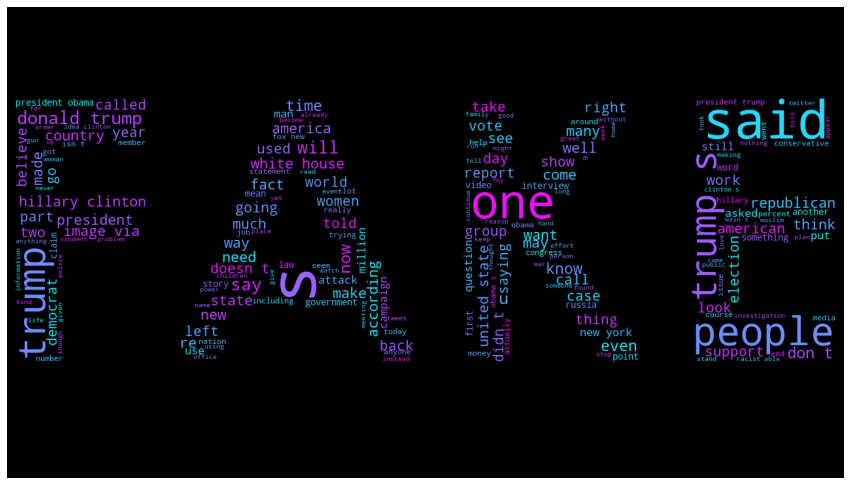

In [124]:
plt.figure(figsize=(15, 10))
plt.imshow(cloud_f.recolor(colormap= 'cool' , random_state=147))
plt.axis('off')
#plt.title('Word Cloud for Fake News')
plt.show()

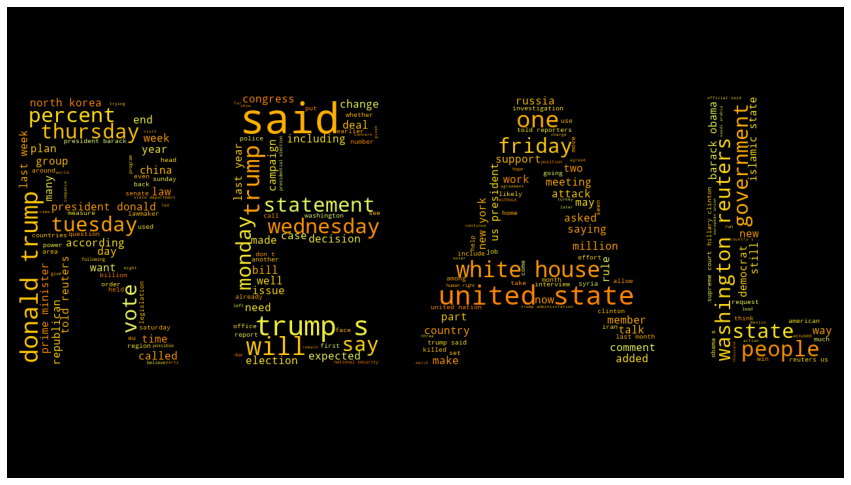

In [125]:
plt.figure(figsize=(15,10))
plt.imshow(cloud_r.recolor(colormap= 'Wistia' , random_state=147))
plt.axis('off')
#plt.title('Word Cloud for Real News')
plt.show()

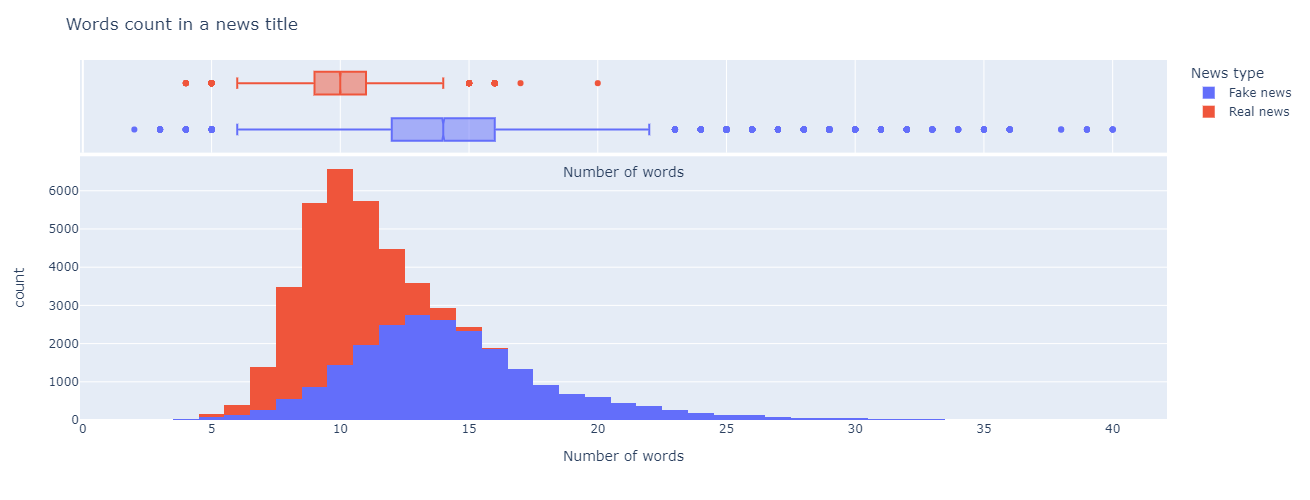

In [148]:
fig = px.histogram(news, x="word_count_title", color="label", marginal='box', labels={"label": "News type"})

fig.update_xaxes(title_text='Number of words')

fig.update_layout(
    autosize=False,
    width=900,
    height=500,
    title_text='Words count in a news title')

fig.for_each_trace(lambda t: t.update(name=newstype[t.name]))

fig.show()

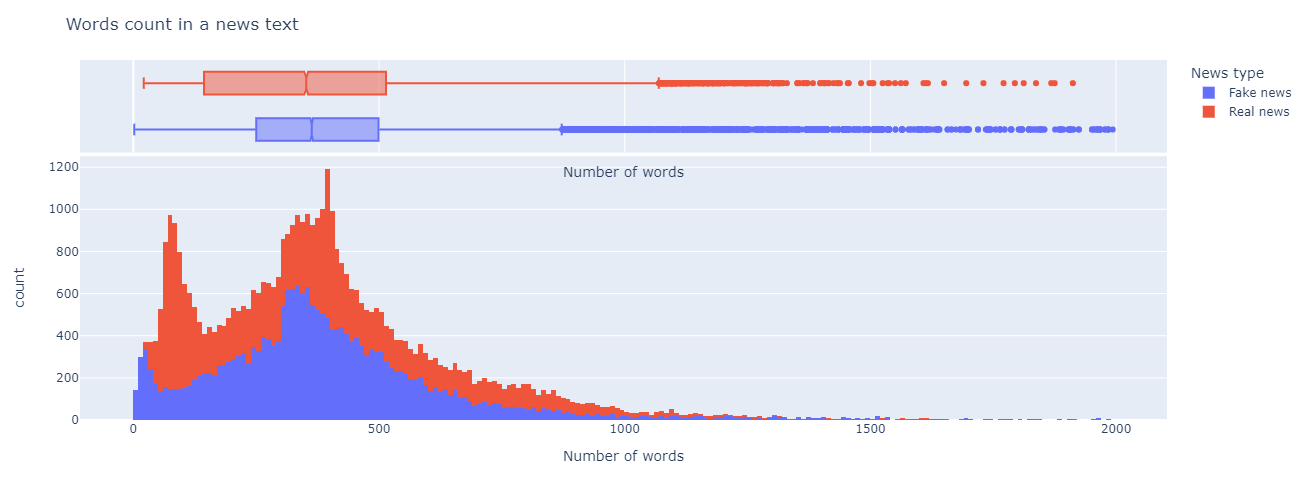

In [149]:
fig = px.histogram(news[news["word_count_text"] <= 2000], x="word_count_text", color="label", marginal='box', labels={"label": "News type"})

fig.update_xaxes(title_text='Number of words')

fig.update_layout(
    autosize=False,
    width=900,
    height=500,
    title_text='Words count in a news text')

fig.for_each_trace(lambda t: t.update(name=newstype[t.name]))

fig.show()

In [179]:
news['subject'].value_counts()

politics       26693
world          10145
left            4278
government      1490
from US          783
middle-east      778
Name: subject, dtype: int64

politicsNews and politics seem to be the same, so let's rename these and some additional column, in order to make it clearly

In [160]:
news.loc[news[news['subject'] == 'politicsNews'].index, 'subject'] = 'politics'

In [175]:
news[news['subject'] == 'News'].sample(frac=.1)['text']

3866    Welcome to Trump s America, a.k.a. Trumplandia...
7095    It was just a few days ago that President Bara...
3529    On Tuesday, Senator Jose Menendez (D-San Anton...
2452    Even from the beginning of his hate-fueled, bi...
3540    Right-wingers everywhere have been trying to d...
                              ...                        
8706    Filmmaker Michael Moore, who was born in Flint...
5171    Last week, RABA Research had Hillary Clinton b...
3098    Viola Davis said that the issue of racial tens...
6495    Ann Coulter is one of those blatantly offensiv...
5003    A right-wing activist secretly spying on a Dem...
Name: text, Length: 905, dtype: object

Rows with News tag look like politics as well

In [176]:
news.loc[news[news['subject'] == 'News'].index, 'subject'] = 'politics'

In [178]:
news.loc[news[news['subject'] == 'worldnews'].index, 'subject'] = 'from world'
news.loc[news[news['subject'] == 'left-news'].index, 'subject'] = 'left'
news.loc[news[news['subject'] == 'Government News'].index, 'subject'] = 'government'
news.loc[news[news['subject'] == 'US_News'].index, 'subject'] = 'from US'
news.loc[news[news['subject'] == 'Middle-east'].index, 'subject'] = 'middle-east'

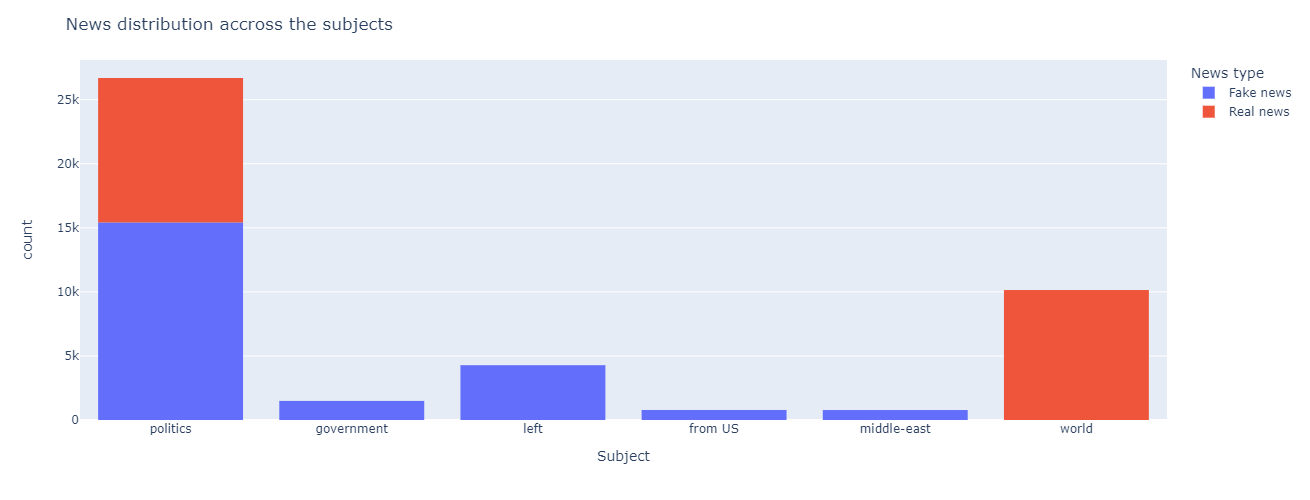

In [180]:
fig = px.histogram(news, x="subject", color="label", labels={"label": "News type"})

fig.update_xaxes(title_text='Subject')

fig.update_layout(
    autosize=False,
    width=900,
    height=500,
    title_text='News distribution accross the subjects')

fig.for_each_trace(lambda t: t.update(name=newstype[t.name]))

fig.show()

So, the news of not trivial subject are only the fakes. There are no fake news from the world at all. It looks like, belonging to the very specific category should make the news more trustworth.

## 2. Data modelling

Creating a class, which contains a necessary methods, that we would love to use in order to test a few models.

In [42]:
class CustomModelWithVectorizer():
    def __init__(self, vectorizer, model, X, y, seed, split_ratio):
        self.vectorizer = vectorizer
        self.model = model
        self.X = X
        self.y = y
        self.seed = seed
        self.split_ratio = split_ratio

    def split_and_vectorize(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                                                test_size=self.split_ratio,
                                                                                random_state=self.seed)
        # vectorizer the data
        start = perf_counter()
        self.vectorizer.fit(self.X)
        self.X_train = self.vectorizer.transform(self.X_train).astype(np.float64)
        self.X_test = self.vectorizer.transform(self.X_test).astype(np.float64)
        end = perf_counter()
        print(f"It took {((end-start)/60):.1f} minutes to vectorize the data")

    def train_and_test(self):
        start = perf_counter()
        self.model.fit(self.X_train, self.y_train)
        end = perf_counter()
        print(f"It took {((end-start)/60):.1f} minutes to train the model")
        # make predictions and test the results
        y_preds = self.model.predict(self.X_test)
        print(f'Accuracy: {self.model.score(self.X_test, self.y_test):.3f}')
        print(f'AUC: {roc_auc_score(self.y_test, y_preds):.3f}')
        print(classification_report(self.y_test, y_preds))
        cm = confusion_matrix(self.y_test, y_preds, labels=self.model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.show()

### Count Vectorizer and TFIDF

### On only cleaned text

#### Count Vectorizer

In [225]:
mnb = CustomModelWithVectorizer(vectorizer=CountVectorizer(ngram_range=(1, 2), max_df=0.9),
                                model=MultinomialNB(),
                                X=news['clean_text'], y=news['label'], seed=147, split_ratio=0.3)

It took 1.3 minutes to vectorize the data
It took 0.0 minutes to train the model
Accuracy: 0.970
AUC: 0.970
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      6365
           1       0.98      0.97      0.97      6886

    accuracy                           0.97     13251
   macro avg       0.97      0.97      0.97     13251
weighted avg       0.97      0.97      0.97     13251



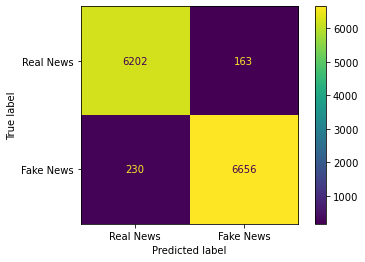

In [226]:
mnb.split_and_vectorize()
mnb.train_and_test()

In [14]:
lgbm = CustomModelWithVectorizer(vectorizer=CountVectorizer(ngram_range=(1, 2), max_df=0.9),
                                model=LGBMClassifier(random_state=147),
                                X=news['clean_text'], y=news['label'], seed=147, split_ratio=0.3)

It took 1.2 minutes to vectorize the data
It took 0.9 minutes to train the model
Accuracy: 0.998
AUC: 0.998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6365
           1       1.00      1.00      1.00      6886

    accuracy                           1.00     13251
   macro avg       1.00      1.00      1.00     13251
weighted avg       1.00      1.00      1.00     13251



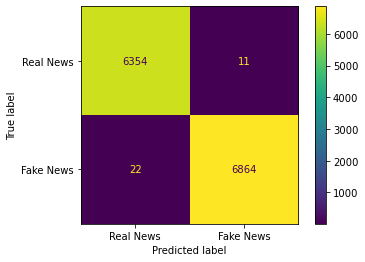

In [15]:
lgbm.split_and_vectorize()
lgbm.train_and_test()

#### TFIDF

In [230]:
logreg_tfidf = CustomModelWithVectorizer(vectorizer=TfidfVectorizer(ngram_range=(1, 2), max_df=0.8),
                                         model=LogisticRegression(C=1.0, max_iter=300, random_state=147),
                                         X=news['clean_text'], y=news['label'], seed=147, split_ratio=0.3)

It took 1.3 minutes to vectorize the data
It took 0.4 minutes to train the model
Accuracy: 0.985
AUC: 0.985
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6365
           1       0.99      0.99      0.99      6886

    accuracy                           0.99     13251
   macro avg       0.99      0.99      0.99     13251
weighted avg       0.99      0.99      0.99     13251



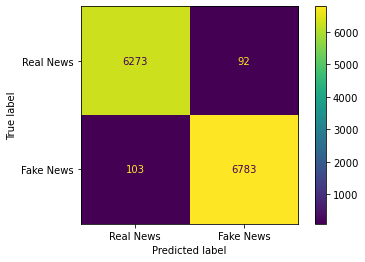

In [231]:
logreg_tfidf.split_and_vectorize()
logreg_tfidf.lgbm.train_and_test()

##### Best TfidfVectorizer on clean_text and overall

In [20]:
lgbm = CustomModelWithVectorizer(vectorizer=TfidfVectorizer(ngram_range=(1, 2), max_df=0.8),
                                model=LGBMClassifier(random_state=147),
                                X=news['clean_text'], y=news['label'], seed=147, split_ratio=0.3)

It took 1.1 minutes to vectorize the data
It took 1.4 minutes to train the model
Accuracy: 0.997
AUC: 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6365
           1       1.00      1.00      1.00      6886

    accuracy                           1.00     13251
   macro avg       1.00      1.00      1.00     13251
weighted avg       1.00      1.00      1.00     13251



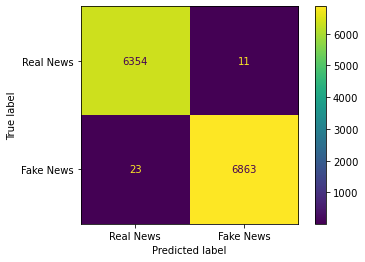

In [21]:
lgbm.split_and_vectorize()
lgbm.train_and_test()

### On processed text

#### Count Vectorizer

In [31]:
mnb = CustomModelWithVectorizer(vectorizer=CountVectorizer(ngram_range=(1, 2), max_df=0.9),
                                model=MultinomialNB(),
                                X=news['processed_text'], y=news['label'], seed=147, split_ratio=0.3)

It took 0.8 minutes to vectorize the data
It took 0.0 minutes to train the model
Accuracy: 0.977
AUC: 0.978
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6382
           1       0.99      0.96      0.98      6868

    accuracy                           0.98     13250
   macro avg       0.98      0.98      0.98     13250
weighted avg       0.98      0.98      0.98     13250



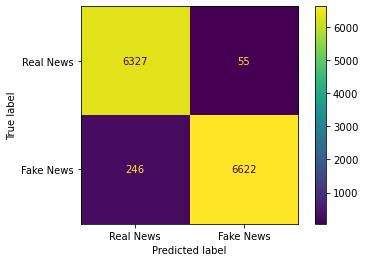

In [32]:
mnb.split_and_vectorize()
mnb.train_and_test()

##### Best Count vectorizer on processed

In [33]:
logreg_tfidf = CustomModelWithVectorizer(vectorizer=CountVectorizer(ngram_range=(1, 2), max_df=0.9),
                                         model=LogisticRegression(C=1.0, max_iter=300, random_state=147),
                                         X=news['processed_text'], y=news['label'], seed=147, split_ratio=0.3)

It took 0.9 minutes to vectorize the data
It took 1.0 minutes to train the model
Accuracy: 0.997
AUC: 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6382
           1       1.00      1.00      1.00      6868

    accuracy                           1.00     13250
   macro avg       1.00      1.00      1.00     13250
weighted avg       1.00      1.00      1.00     13250



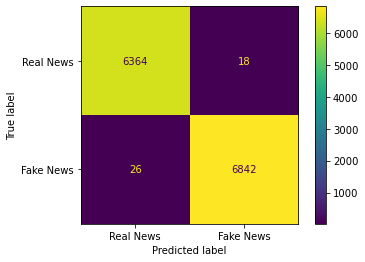

In [34]:
logreg_tfidf.split_and_vectorize()
logreg_tfidf.train_and_test()

#### TFIDF

In [37]:
mnb = CustomModelWithVectorizer(vectorizer=CountVectorizer(ngram_range=(1, 2), max_df=0.9),
                                model=MultinomialNB(),
                                X=news['processed_text'], y=news['label'], seed=147, split_ratio=0.3)

It took 0.8 minutes to vectorize the data
It took 0.0 minutes to train the model
Accuracy: 0.977
AUC: 0.978
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6382
           1       0.99      0.96      0.98      6868

    accuracy                           0.98     13250
   macro avg       0.98      0.98      0.98     13250
weighted avg       0.98      0.98      0.98     13250



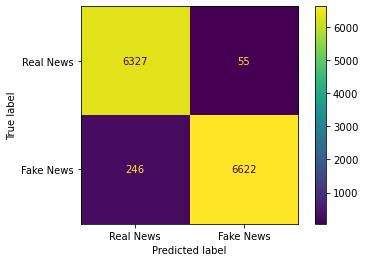

In [38]:
mnb.split_and_vectorize()
mnb.train_and_test()

In [39]:
logreg_tfidf = CustomModelWithVectorizer(vectorizer=TfidfVectorizer(ngram_range=(1, 2), max_df=0.8),
                                         model=LogisticRegression(C=1.0, max_iter=300, random_state=147),
                                         X=news['processed_text'], y=news['label'], seed=147, split_ratio=0.3)

It took 1.0 minutes to vectorize the data
It took 0.3 minutes to train the model
Accuracy: 0.987
AUC: 0.987
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6382
           1       0.99      0.99      0.99      6868

    accuracy                           0.99     13250
   macro avg       0.99      0.99      0.99     13250
weighted avg       0.99      0.99      0.99     13250



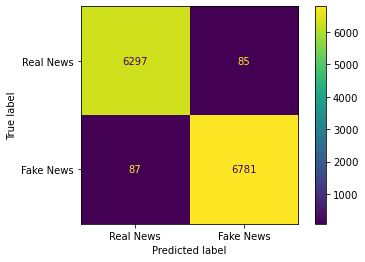

In [40]:
logreg_tfidf.split_and_vectorize()
logreg_tfidf.train_and_test()

There are actually a lot of good models left and there are a lot of others possibilities for prerpocessing the data, but everything, what have been done so far yield a very good results. Best Model overall on only cleaned text (without stemming and lemmatization) is LightGBM and could be easy used for identifying fake or real news, followed by Logistic Regression on processed text (stemming+lemmatization). In terms of speed the LightGBM model will be the choice, because then we do not need to apply additional processing rules, which cost some time.

## Conclusions:
- There are some interesting patterns in data set:
    * All over the year fake news have been published more often, though only in 4th quartal the real news were dominating.
    * In terms of weekdays, real news are coming very rare on Weekends if in comparison with fakes.
    * Both titles and texts in fake news are shorter on average, but the spread of values is much more higher (variance)
- It is relative clear from, that lots of words with the highest frequency are shared across both categories, but words with the lowest occurance are pretty different in each categories and helping to distinguish these two very well, that what we see in models after cutting the most common words during the vectorization procedure.